# Feature Engineering — Yearly BMW Sales

We are preparing a clean, yearly-aggregated sales dataset for time series forecasting using Prophet. This table will be used as the basis for modeling and trend analysis.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Load the same CSV used in EDA
df = pd.read_csv('../data/processed/BMW_Worldwide_Sales_Cleaned.csv')

# Ensure Year is numeric
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Aggregate yearly sales
df_year = df.groupby('Year', as_index=False).agg({'Sales_Volume': 'sum'})
df_year.rename(columns={'Sales_Volume': 'Total_Sales'}, inplace=True)
df_year = df_year.sort_values('Year').reset_index(drop=True)


## Year-over-Year Growth

Year-over-year (YoY) growth helps us understand the momentum and direction of total BMW sales over time.

In [20]:
df_year['YoY_Growth'] = df_year['Total_Sales'].pct_change() * 100

## Optional Log Transform

A log transform can help stabilize variance in sales data, which is sometimes useful for forecasting, but it is optional.

In [21]:
df_year['Log_Sales'] = np.log1p(df_year['Total_Sales'])

## Preview Feature Table

Sanity check: preview the yearly features table.

In [22]:
df_year.head()

,Year,Total_Sales,YoY_Growth,Log_Sales
0,2010,16933445,NaN,16.644801
1,2011,16758941,-1.030529,16.634443
2,2012,16751895,-0.042043,16.634022
3,2013,16866733,0.685522,16.640854
4,2014,16958960,0.546798,16.646307


## Save Dataset for Forecasting

This is the final yearly dataset for use in `04_prediction.ipynb` with Prophet.

In [23]:
df_year.to_csv('../data/processed/yearly_sales.csv', index=False)

## 2. Market Segmentation Features

Creating features for market analysis:
- Price categorization
- Market segment definition
- Vehicle age and condition metrics
- Engine power categories
- Environmental classification

In [24]:
# Create Vehicle_Type feature first (needed for later analysis)
df['Vehicle_Type'] = df['Model'].apply(
    lambda x: 'SUV' if x in ['X1', 'X3', 'X5', 'X6', 'X7']
    else 'Sedan' if x in ['3 Series', '5 Series', '7 Series']
    else 'Sports' if x in ['M3', 'M5', 'Z4']
    else 'Other'
)

# Price-related features
df['Price_Category'] = pd.qcut(
    df['Price_USD'], 
    q=5, 
    labels=['Budget', 'Entry', 'Mid', 'Premium', 'Luxury'], 
    duplicates='drop'
)

# Handle division by zero in price per km calculation
df['Price_Per_KM'] = np.where(
    df['Mileage_KM'] > 0,
    df['Price_USD'] / df['Mileage_KM'],
    np.nan
)

# Market segments (with more detailed segmentation)
df['Market_Segment'] = df.apply(
    lambda x: 'Ultra-Luxury' if x['Model'] in ['7 Series']
    else 'Premium' if x['Model'] in ['5 Series', 'X5', 'X6']
    else 'Performance' if x['Model'] in ['M3', 'M5']
    else 'Entry', axis=1
)

# Vehicle age and condition
current_year = int(df['Year'].max())
df['Vehicle_Age'] = current_year - df['Year']
df['Age_Category'] = pd.cut(
    df['Vehicle_Age'],
    bins=[-np.inf, 0, 3, 6, np.inf],
    labels=['New', 'Recent', 'Mid-Age', 'Older']
)

# Engine and efficiency features
df['Engine_Power_Category'] = pd.cut(
    df['Engine_Size_L'], 
    bins=[0, 2.0, 3.0, 4.0, float('inf')],
    labels=['Economic', 'Mid-Power', 'High-Power', 'Ultra']
)

# Environmental features
df['Green_Vehicle'] = df['Fuel_Type'].isin(['Electric', 'Hybrid'])
df['Region_Green_Focus'] = df.apply(
    lambda x: 1 if x['Green_Vehicle'] and x['Region'] in ['Europe', 'North America'] else 0, 
    axis=1
)

# Display new features with better formatting
print("\nSample of new market segmentation features:")
display(df[['Model', 'Vehicle_Type', 'Market_Segment', 'Age_Category', 'Price_Category', 'Engine_Power_Category', 'Green_Vehicle']].head(10))

print("\nFeature value distributions:")
for col in ['Vehicle_Type', 'Market_Segment', 'Age_Category', 'Price_Category', 'Engine_Power_Category']:
    print(f"\n{col} distribution:")
    print(df[col].value_counts(normalize=True).round(3) * 100)



Sample of new market segmentation features:


,Model,Vehicle_Type,Market_Segment,Age_Category,Price_Category,Engine_Power_Category,Green_Vehicle
0,5 Series,Sedan,Premium,Older,Premium,High-Power,False
1,i8,Other,Entry,Older,Mid,Economic,True
2,5 Series,Sedan,Premium,Recent,Luxury,Ultra,False
3,X3,SUV,Entry,New,Entry,Economic,False
4,7 Series,Sedan,Ultra-Luxury,Mid-Age,Entry,Mid-Power,False
5,5 Series,Sedan,Premium,Older,Budget,Economic,False
6,i8,Other,Entry,Recent,Entry,Economic,False
7,M5,Sports,Performance,Older,Luxury,Economic,False
8,X3,SUV,Entry,Older,Luxury,Economic,False
9,i8,Other,Entry,Mid-Age,Premium,Mid-Power,True



Feature value distributions:

Vehicle_Type distribution:
Vehicle_Type
SUV       36.1
Sedan     27.7
Other     18.4
Sports    17.8
Name: proportion, dtype: float64

Market_Segment distribution:
Market_Segment
Entry           45.8
Premium         27.1
Performance     17.8
Ultra-Luxury     9.3
Name: proportion, dtype: float64

Age_Category distribution:
Age_Category
Older      53.3
Recent     20.1
Mid-Age    19.8
New         6.9
Name: proportion, dtype: float64

Price_Category distribution:
Price_Category
Mid        20.0
Budget     20.0
Entry      20.0
Luxury     20.0
Premium    20.0
Name: proportion, dtype: float64

Engine_Power_Category distribution:
Engine_Power_Category
High-Power    28.6
Mid-Power     28.6
Ultra         27.0
Economic      15.7
Name: proportion, dtype: float64


## 3. Market Performance Metrics

Calculating key market performance indicators:
- Overall market share
- Segment-specific performance
- Regional market strength
- Sales volume analysis

In [25]:
# Group features for consistent analysis
base_features = ['Model', 'Region', 'Color', 'Fuel_Type', 'Transmission']
engineered_features = ['Vehicle_Type', 'Market_Segment', 'Price_Category', 'Engine_Power_Category']
numeric_features = ['Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Vehicle_Age']

# Market share calculations
df['Total_Year_Sales'] = df.groupby('Year')['Sales_Volume'].transform('sum')
df['Market_Share'] = (df['Sales_Volume'] / df['Total_Year_Sales']) * 100

# Segment performance by vehicle type and market segment
for segment_col in ['Vehicle_Type', 'Market_Segment']:
    df[f'{segment_col}_Sales'] = df.groupby(['Year', segment_col])['Sales_Volume'].transform('sum')
    df[f'{segment_col}_Share'] = (df['Sales_Volume'] / df[f'{segment_col}_Sales']) * 100

# Regional market strength with more granular analysis
df['Region_Year_Sales'] = df.groupby(['Year', 'Region'])['Sales_Volume'].transform('sum')
df['Regional_Share'] = (df['Sales_Volume'] / df['Region_Year_Sales']) * 100

# Comprehensive market analysis
print("Market analysis by vehicle type and segment:")
market_summary = pd.DataFrame()

# Vehicle Type analysis
vtype_summary = df.groupby('Vehicle_Type').agg({
    'Sales_Volume': 'sum',
    'Market_Share': 'mean',
    'Vehicle_Type_Share': 'mean',
    'Price_USD': ['mean', 'std']
}).round(2)
vtype_summary.columns = ['Total_Sales', 'Avg_Market_Share', 'Segment_Share', 'Avg_Price', 'Price_Std']
print("\nVehicle Type Performance:")
display(vtype_summary.sort_values('Total_Sales', ascending=False))

# Market Segment analysis
segment_summary = df.groupby('Market_Segment').agg({
    'Sales_Volume': 'sum',
    'Market_Share': 'mean',
    'Market_Segment_Share': 'mean',
    'Price_USD': ['mean', 'std']
}).round(2)
segment_summary.columns = ['Total_Sales', 'Avg_Market_Share', 'Segment_Share', 'Avg_Price', 'Price_Std']
print("\nMarket Segment Performance:")
display(segment_summary.sort_values('Total_Sales', ascending=False))

# Region analysis
region_summary = df.groupby('Region').agg({
    'Sales_Volume': 'sum',
    'Market_Share': 'mean',
    'Regional_Share': 'mean',
    'Green_Vehicle': 'mean'  # Showing environmental focus by region
}).round(2)
print("\nRegional Performance:")
display(region_summary.sort_values('Sales_Volume', ascending=False))

Market analysis by vehicle type and segment:

Vehicle Type Performance:


,Total_Sales,Avg_Market_Share,Segment_Share,Avg_Price,Price_Std
Vehicle_Type,,,,,
SUV,91523324,0.03,0.08,74857.56,26043.26
Sedan,70165288,0.03,0.11,75475.29,26084.48
Other,46557740,0.03,0.16,75082.90,25740.02
Sports,45129382,0.03,0.17,74656.92,26033.40



Market Segment Performance:


,Total_Sales,Avg_Market_Share,Segment_Share,Avg_Price,Price_Std
Market_Segment,,,,,
Entry,115990632,0.03,0.07,75202.73,25952.68
Premium,68469254,0.03,0.11,74814.14,26097.80
Performance,45129382,0.03,0.17,74656.92,26033.40
Ultra-Luxury,23786466,0.03,0.32,75570.20,25856.58



Regional Performance:


,Sales_Volume,Market_Share,Regional_Share,Green_Vehicle
Region,,,,
Asia,42974277,0.03,0.18,0.51
Europe,42555138,0.03,0.18,0.51
North America,42402629,0.03,0.18,0.51
Middle East,42326620,0.03,0.18,0.50
Africa,41565252,0.03,0.18,0.50
South America,41551818,0.03,0.18,0.50


## 4. Time Series Analysis

Temporal analysis of sales data:
- Year-over-year growth calculation
- Rolling averages
- Growth distribution analysis
- Model performance trends

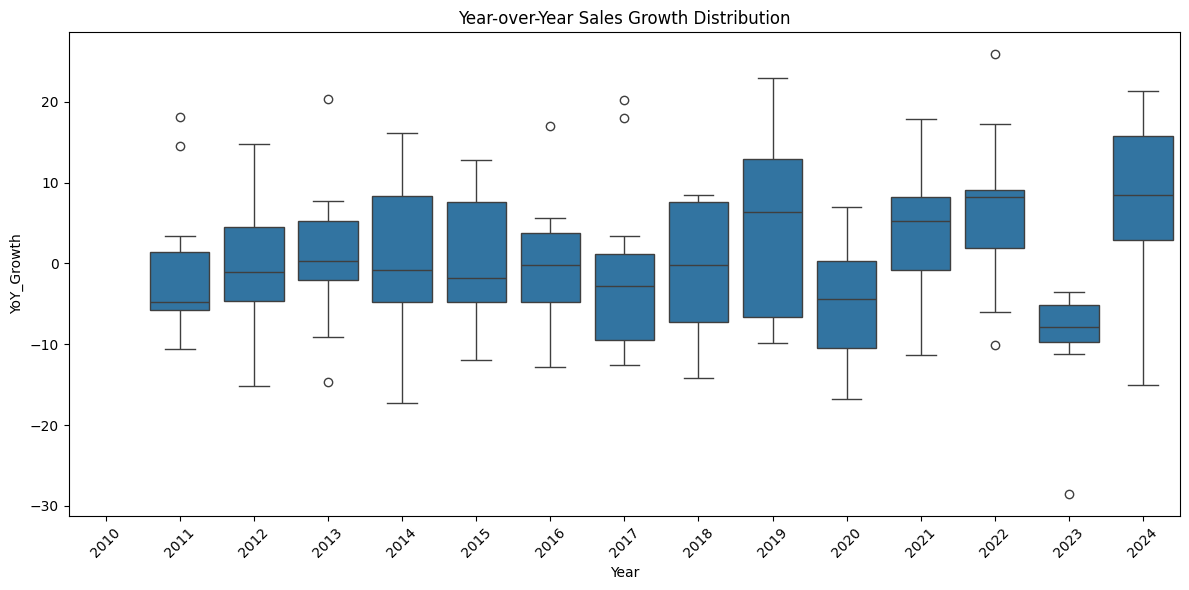


Top 5 models by average YoY growth:


Model
X6          2.053836
7 Series    1.888519
5 Series    1.463034
M5          0.884328
i3          0.830227
Name: YoY_Growth, dtype: float64

In [26]:
# Calculate year-over-year growth by model and vehicle type
yearly_sales = df.groupby(['Year', 'Model'])['Sales_Volume'].sum().reset_index()
yearly_sales['Last_Year_Sales'] = yearly_sales.groupby('Model')['Sales_Volume'].shift(1)
yearly_sales['YoY_Growth'] = (yearly_sales['Sales_Volume'] - yearly_sales['Last_Year_Sales']) / yearly_sales['Last_Year_Sales'] * 100

# Calculate rolling averages
yearly_sales['3Y_Avg_Sales'] = yearly_sales.groupby('Model')['Sales_Volume'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)

# Plot YoY growth trends
plt.figure(figsize=(12, 6))
sns.boxplot(data=yearly_sales, x='Year', y='YoY_Growth')
plt.title('Year-over-Year Sales Growth Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTop 5 models by average YoY growth:")
display(yearly_sales.groupby('Model')['YoY_Growth'].mean().sort_values(ascending=False).head())

## 5. Feature Importance Analysis

Statistical analysis of feature impact:
- Feature group importance
- Individual feature significance
- Correlation analysis
- Impact on sales performance

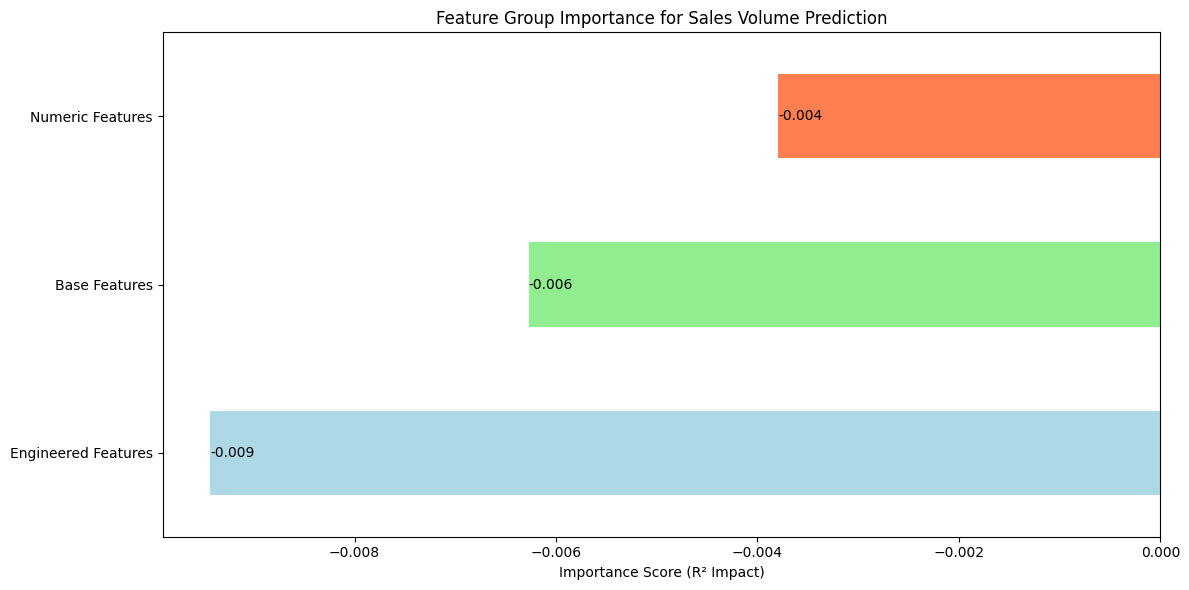

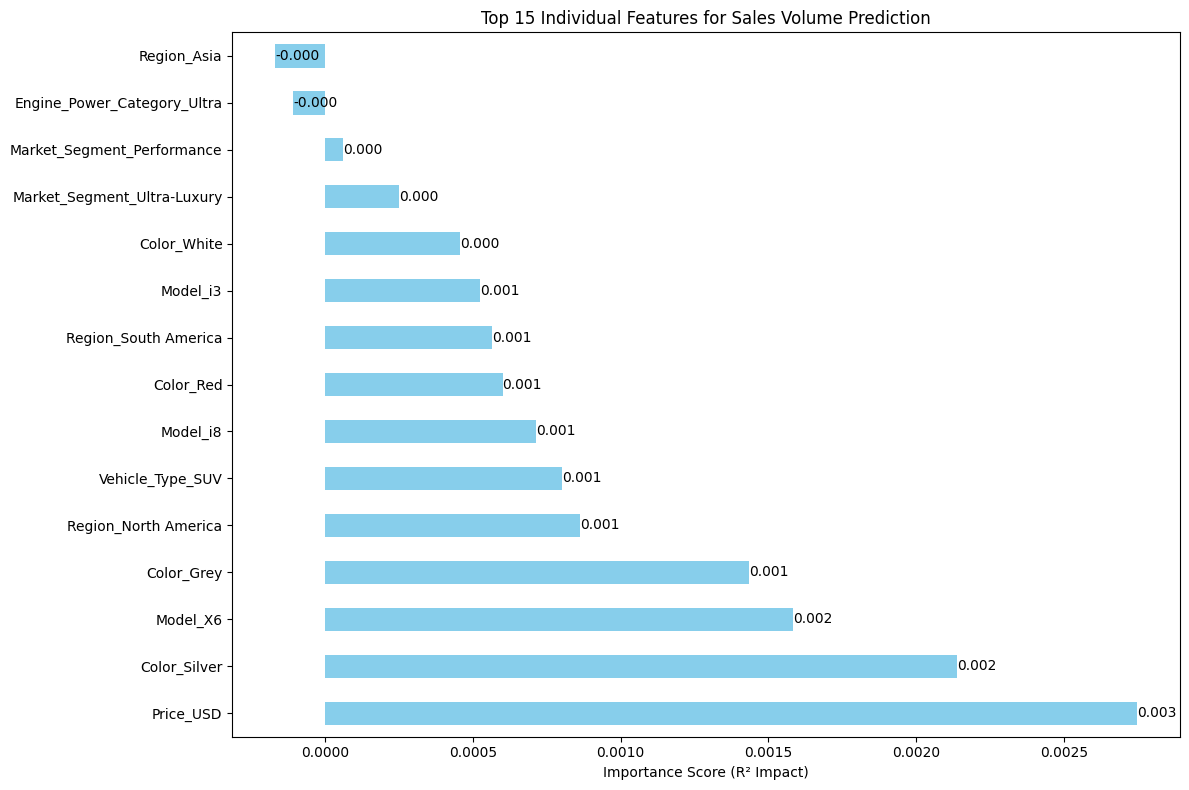


Top 15 most important individual features:
Price_USD                      0.0027
Color_Silver                   0.0021
Model_X6                       0.0016
Color_Grey                     0.0014
Region_North America           0.0009
Vehicle_Type_SUV               0.0008
Model_i8                       0.0007
Color_Red                      0.0006
Region_South America           0.0006
Model_i3                       0.0005
Color_White                    0.0005
Market_Segment_Ultra-Luxury    0.0003
Market_Segment_Performance     0.0001
Engine_Power_Category_Ultra   -0.0001
Region_Asia                   -0.0002
dtype: float64


In [27]:
# Prepare features for importance analysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

# Define features to analyze
base_features = ['Model', 'Region', 'Color', 'Fuel_Type', 'Transmission']
engineered_features = ['Vehicle_Type', 'Market_Segment', 'Price_Category', 'Engine_Power_Category']
numeric_features = ['Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Vehicle_Age']

# Function to calculate feature importance using permutation
def calculate_feature_importance(X, y, feature_names):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale numeric features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)
    
    # Calculate base score
    base_score = r2_score(y_test, rf.predict(X_test_scaled))
    
    # Calculate importance by permutation
    importance_scores = []
    for i in range(X_test_scaled.shape[1]):
        X_test_permuted = X_test_scaled.copy()
        X_test_permuted[:, i] = np.random.permutation(X_test_permuted[:, i])
        permuted_score = r2_score(y_test, rf.predict(X_test_permuted))
        importance = base_score - permuted_score
        importance_scores.append(importance)
    
    return pd.Series(importance_scores, index=feature_names)

# Prepare data for both categorical and numeric features
X_categorical = pd.get_dummies(df[base_features + engineered_features], drop_first=True)
X_numeric = df[numeric_features].copy()

# Combine features
X_combined = pd.concat([X_categorical, X_numeric], axis=1)
y = df['Sales_Volume']

# Calculate feature importance
importance_scores = calculate_feature_importance(X_combined.values, y, X_combined.columns)

# Group importance by feature type
feature_groups = {
    'Base Features': [col for col in X_combined.columns if any(f in col for f in base_features)],
    'Engineered Features': [col for col in X_combined.columns if any(f in col for f in engineered_features)],
    'Numeric Features': numeric_features
}

grouped_importance = {}
for group, features in feature_groups.items():
    group_scores = importance_scores[features]
    grouped_importance[group] = group_scores.sum()

# Plot grouped importance
plt.figure(figsize=(12, 6))
group_df = pd.Series(grouped_importance).sort_values(ascending=True)
ax = group_df.plot(kind='barh', color=['lightblue', 'lightgreen', 'coral'])
plt.title('Feature Group Importance for Sales Volume Prediction')
plt.xlabel('Importance Score (R² Impact)')

# Add value labels
for i, v in enumerate(group_df.values):
    ax.text(v, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

# Plot top individual features
top_n = 15
top_features = importance_scores.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(12, 8))
ax = top_features.plot(kind='barh', color='skyblue')
plt.title(f'Top {top_n} Individual Features for Sales Volume Prediction')
plt.xlabel('Importance Score (R² Impact)')

# Add value labels
for i, v in enumerate(top_features.values):
    ax.text(v, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

print("\nTop 15 most important individual features:")
print(top_features.round(4))


## 6. Data Visualization

Comprehensive visualization of patterns:
- Market segment evolution
- Price-sales relationships
- Regional preferences
- Environmental trends

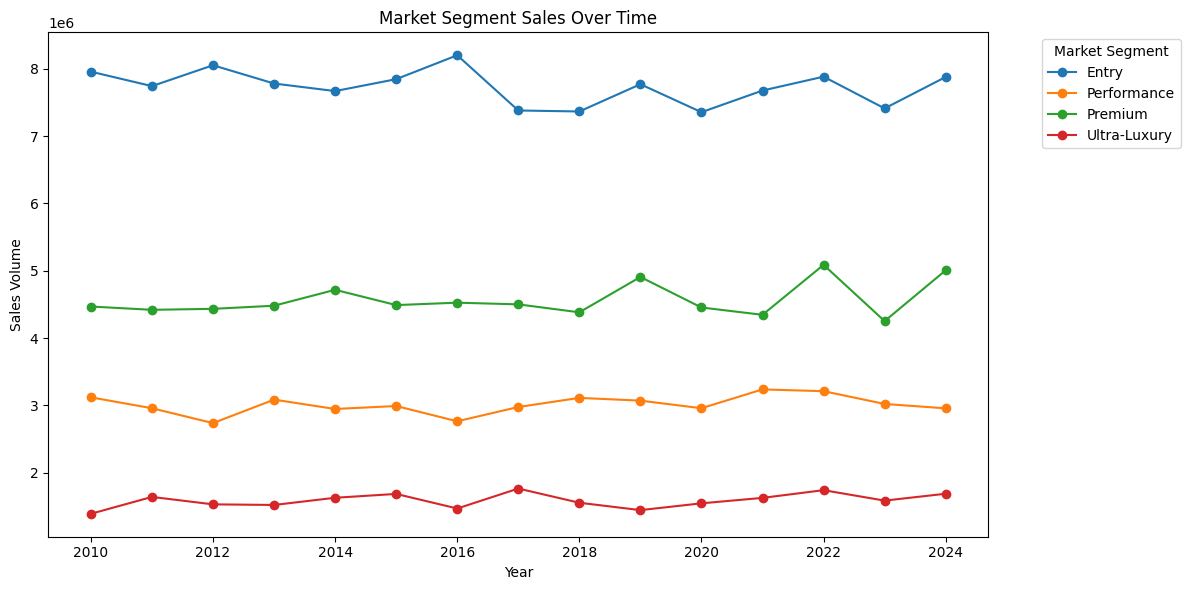

In [28]:
# PLOT A: Market Segment Sales Over Time
segment_trends = df.groupby(['Year', 'Market_Segment'])['Sales_Volume'].sum().reset_index()
plt.figure(figsize=(12, 6))
for segment in segment_trends['Market_Segment'].unique():
    seg_data = segment_trends[segment_trends['Market_Segment'] == segment]
    plt.plot(seg_data['Year'], seg_data['Sales_Volume'], marker='o', label=segment)
plt.title('Market Segment Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Sales Volume')
plt.legend(title='Market Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


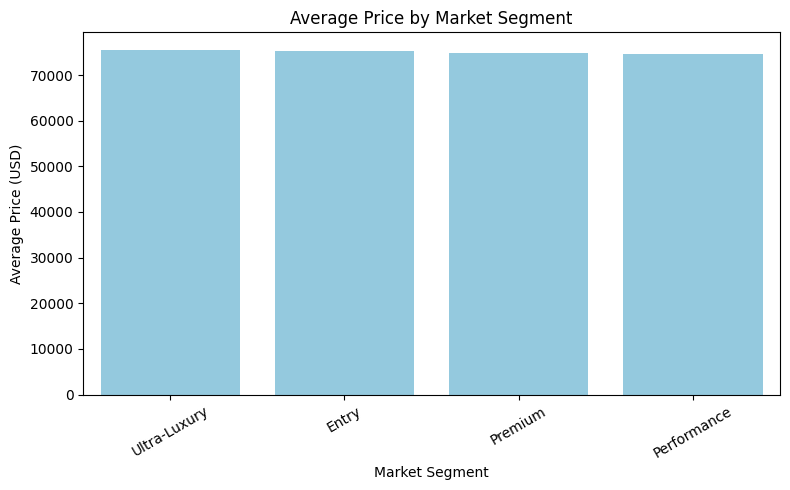

In [29]:
# PLOT B: Average Price by Market Segment
segment_price = df.groupby('Market_Segment')['Price_USD'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=segment_price.index, y=segment_price.values, color='skyblue')
plt.title('Average Price by Market Segment')
plt.xlabel('Market Segment')
plt.ylabel('Average Price (USD)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


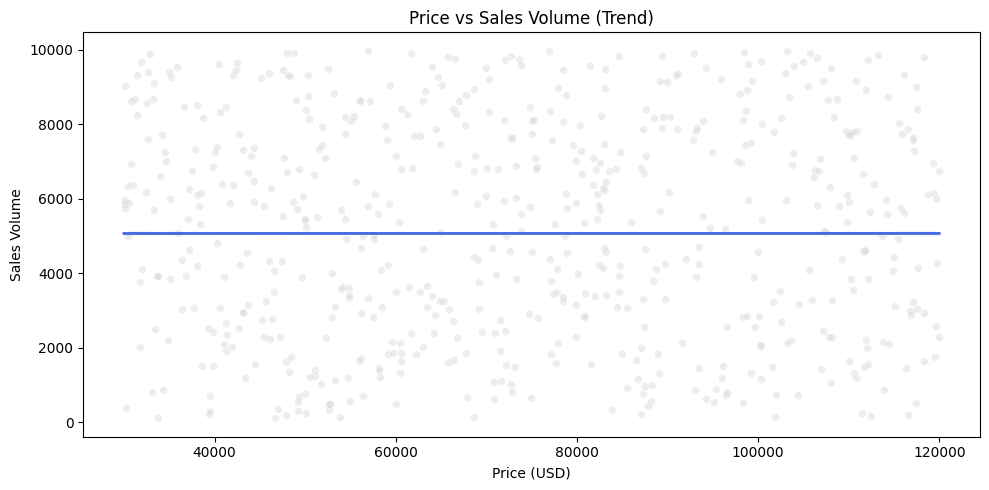

In [30]:
# PLOT C: Price vs Sales Volume (Trend)
sample_df = df.sample(n=min(600, len(df)), random_state=42)
plt.figure(figsize=(10, 5))
sns.scatterplot(data=sample_df, x='Price_USD', y='Sales_Volume', color='lightgray', alpha=0.4, s=30)
sns.regplot(data=df, x='Price_USD', y='Sales_Volume', scatter=False, color='royalblue', line_kws={'lw':2})
plt.title('Price vs Sales Volume (Trend)')
plt.xlabel('Price (USD)')
plt.ylabel('Sales Volume')
plt.tight_layout()
plt.show()


**Insight:**

The overall relationship between price and sales volume is roughly flat to slightly negative. By segment, Premium shows a very slight positive correlation, while Entry, Performance, and Ultra-Luxury are slightly negative—overall effects are weak.

**Insight:**

Ultra-Luxury models have the highest average prices, followed by Entry, then Premium and Performance. The differences are relatively small, indicating tight pricing bands across segments rather than a steep step-up.

**Insight:**

The line plot shows how each market segment's sales volume has evolved over time. Entry and Premium segments consistently lead in volume, while Ultra-Luxury and Performance remain niche. This highlights the importance of mainstream segments for sustained growth.

## 7. Additional Analysis & Visualizations

Advanced analysis including correlation matrices, sales trends, and market insights.

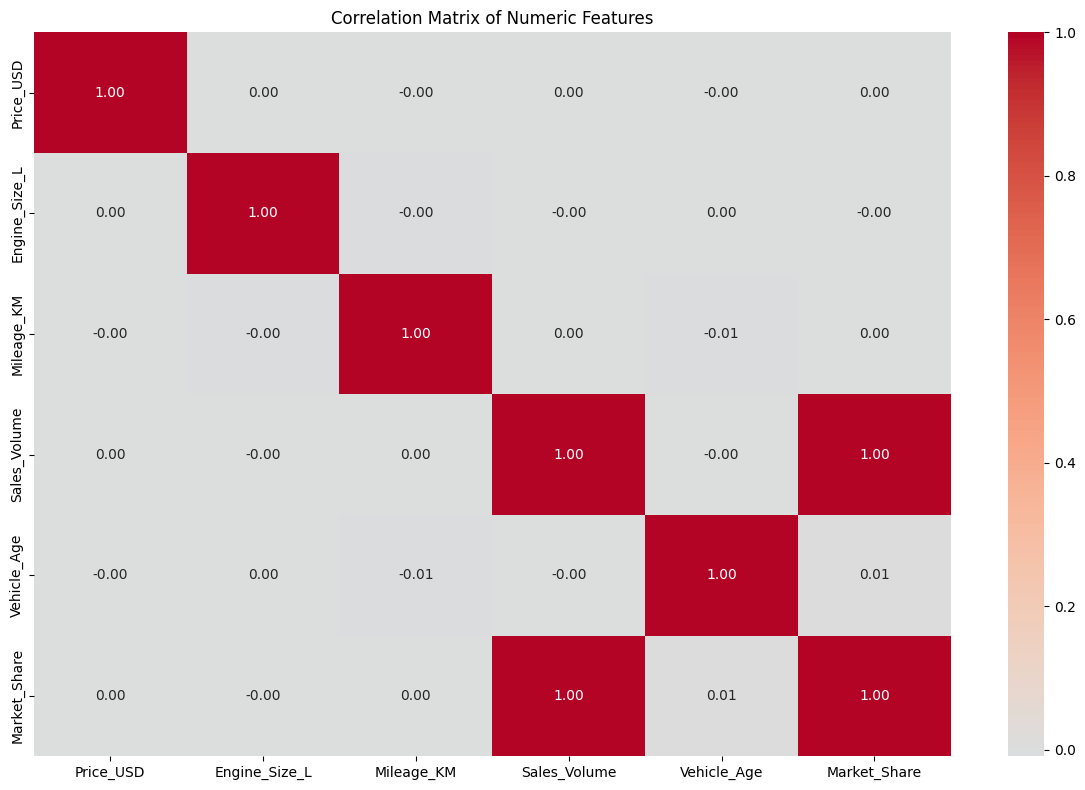

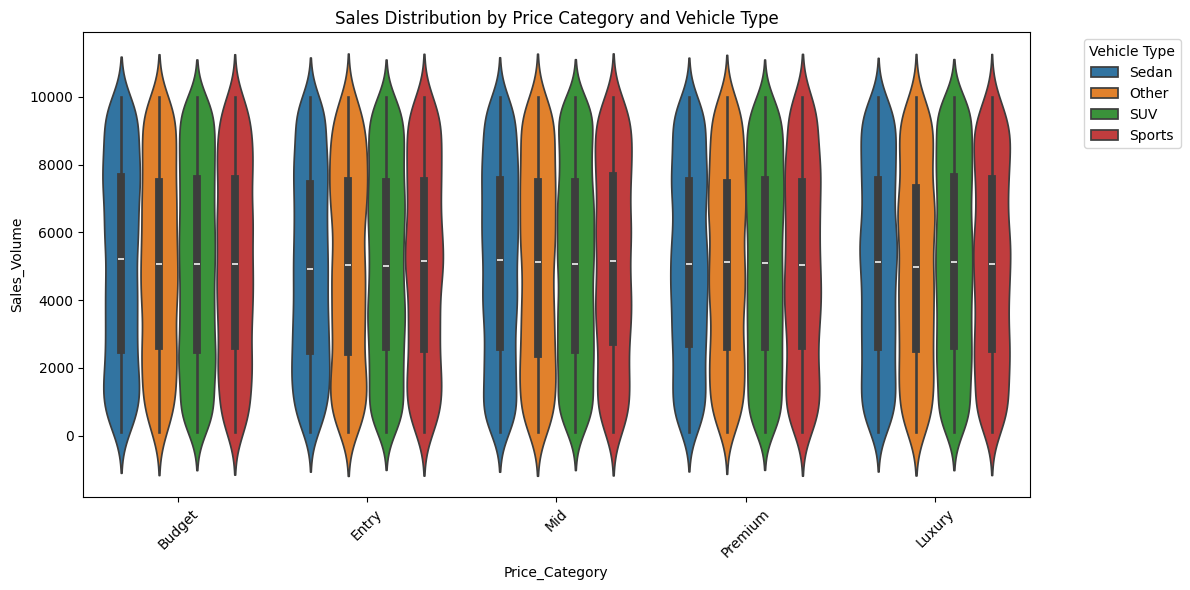

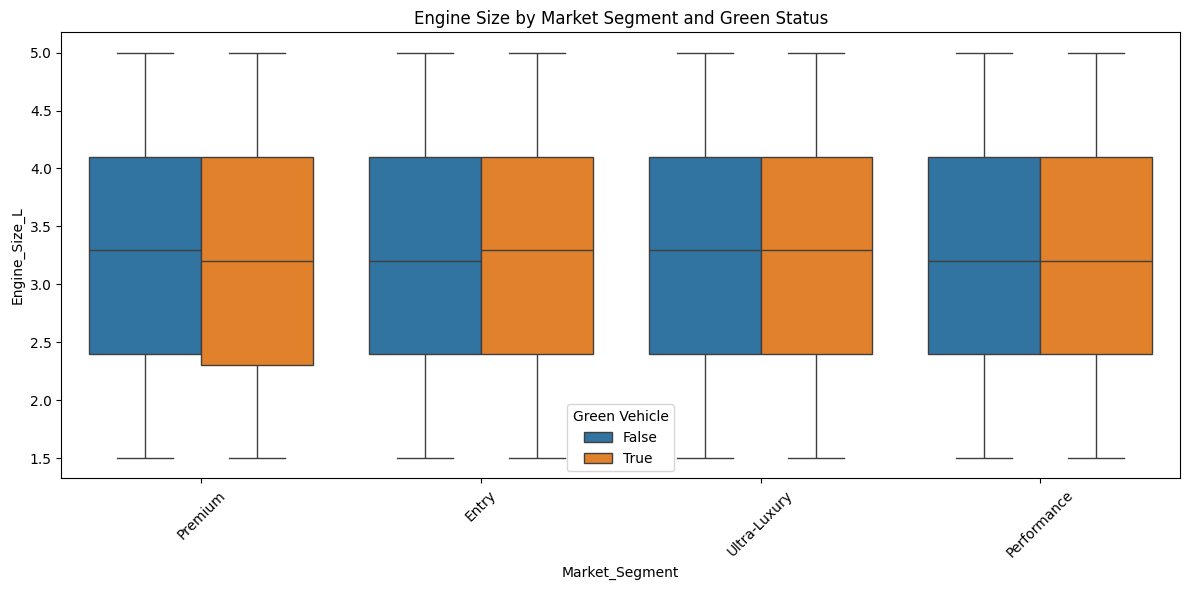

<Figure size 1200x600 with 0 Axes>

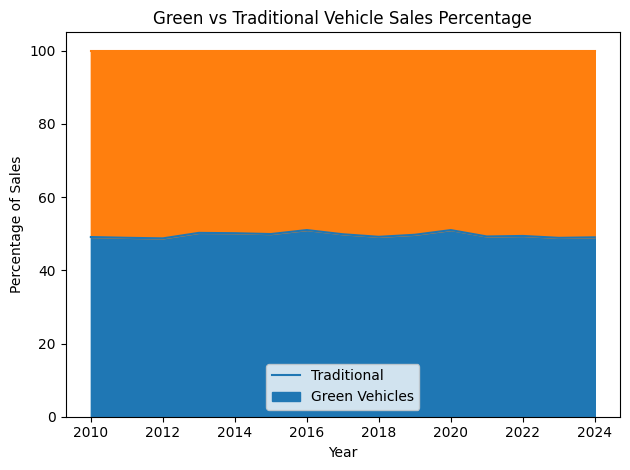

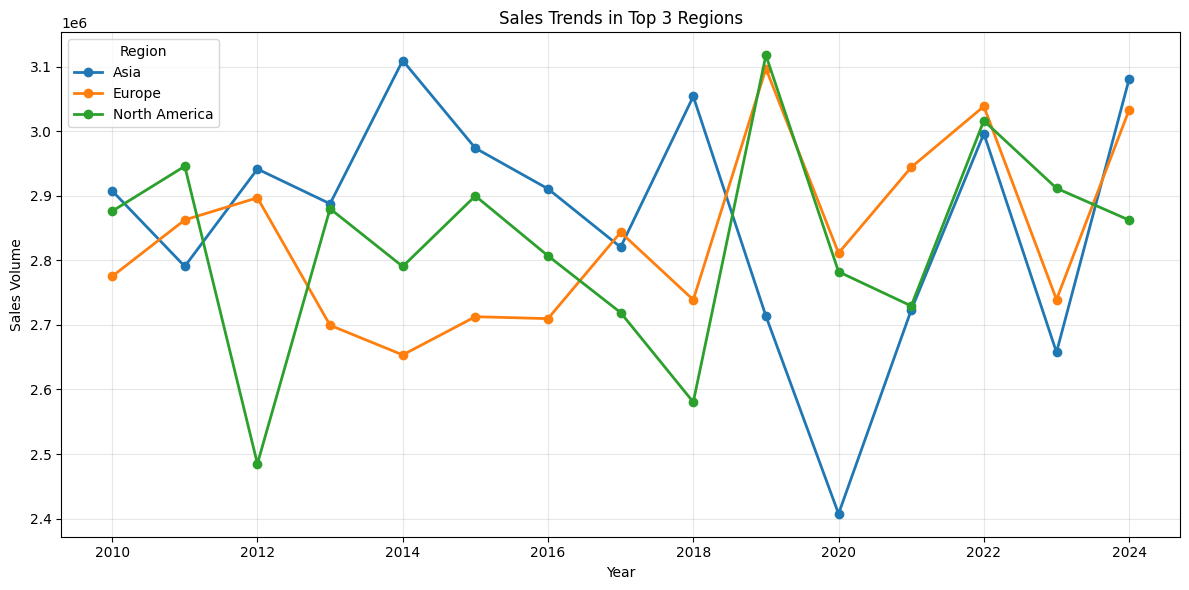

<Figure size 1500x600 with 0 Axes>

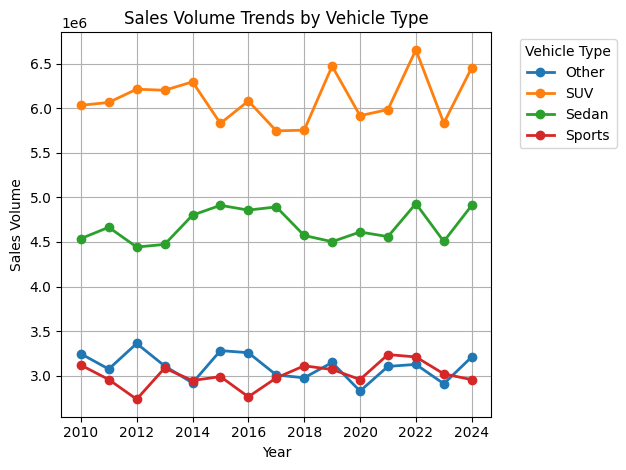


Key Performance Indicators:


,Metric,Value
0,Total Sales Volume,"253,375,734"
1,Average Price (USD),"$75,034.60"
2,Green Vehicle Percentage,50.4%
3,Premium Segment Share,27.1%
4,Top Selling Model,7 Series
5,Most Profitable Region,Asia


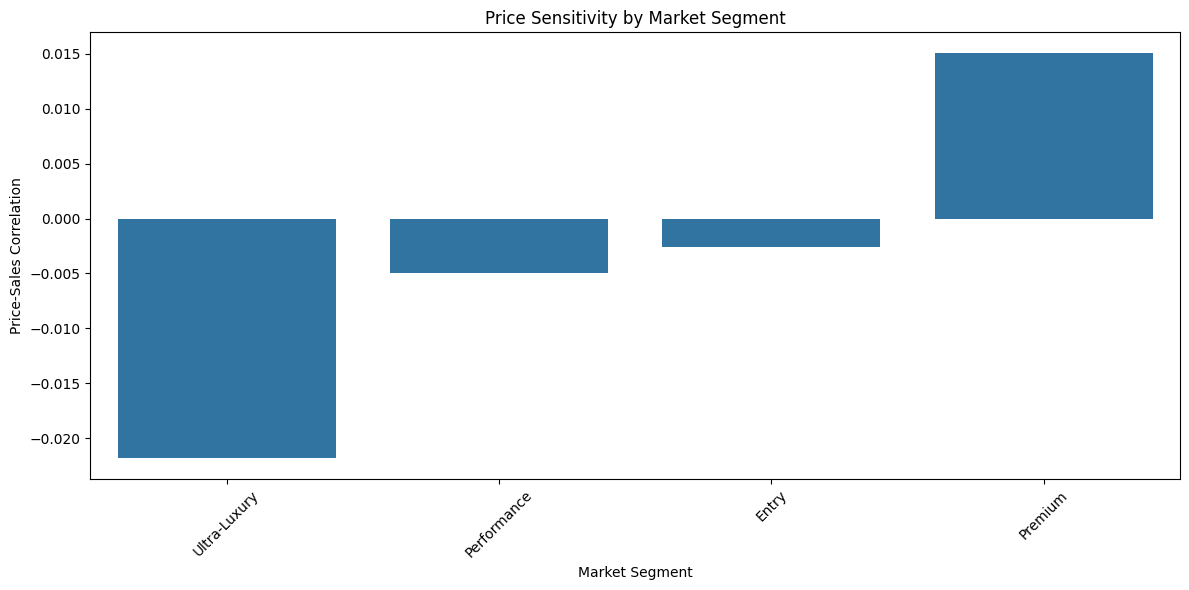


Insights from Price Sensitivity Analysis:
Ultra-Luxury: weak negative correlation (-0.02)
Performance: weak negative correlation (-0.00)
Entry: weak negative correlation (-0.00)
Premium: weak positive correlation (0.02)


In [31]:
# 1. Correlation Analysis
plt.figure(figsize=(12, 8))
# Select only numeric columns that exist in the dataframe
numeric_cols = ['Price_USD', 'Engine_Size_L', 'Mileage_KM', 'Sales_Volume', 'Vehicle_Age']
# Add Market_Share if it exists (created in section 3)
if 'Market_Share' in df.columns:
    numeric_cols.append('Market_Share')
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# 2a. Price Category vs Sales Volume by Vehicle Type
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='Price_Category', y='Sales_Volume', hue='Vehicle_Type')
plt.title('Sales Distribution by Price Category and Vehicle Type')
plt.xticks(rotation=45)
plt.legend(title='Vehicle Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# 2b. Engine Size Distribution by Market Segment
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Market_Segment', y='Engine_Size_L', hue='Green_Vehicle')
plt.title('Engine Size by Market Segment and Green Status')
plt.xticks(rotation=45)
plt.legend(title='Green Vehicle', loc='best')
plt.tight_layout()
plt.show()

# 2c. Green Vehicle Adoption Over Time
plt.figure(figsize=(12, 6))
yearly_green = df.groupby(['Year', 'Green_Vehicle'])['Sales_Volume'].sum().unstack()
yearly_green_pct = yearly_green.div(yearly_green.sum(axis=1), axis=0) * 100
yearly_green_pct.plot(kind='area', stacked=True)
plt.title('Green vs Traditional Vehicle Sales Percentage')
plt.ylabel('Percentage of Sales')
plt.xlabel('Year')
plt.legend(['Traditional', 'Green Vehicles'])
plt.tight_layout()
plt.show()

# 2d. Regional Market Evolution
plt.figure(figsize=(12, 6))
top_regions = df.groupby('Region')['Sales_Volume'].sum().nlargest(3).index
for region in top_regions:
    region_data = df[df['Region'] == region].groupby('Year')['Sales_Volume'].sum()
    plt.plot(region_data.index, region_data.values, marker='o', label=region, linewidth=2)
plt.title('Sales Trends in Top 3 Regions')
plt.xlabel('Year')
plt.ylabel('Sales Volume')
plt.legend(title='Region')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Sales Volume Trends by Vehicle Type
plt.figure(figsize=(15, 6))
yearly_vehicle_sales = df.groupby(['Year', 'Vehicle_Type'])['Sales_Volume'].sum().unstack()
yearly_vehicle_sales.plot(marker='o', linewidth=2)
plt.title('Sales Volume Trends by Vehicle Type')
plt.xlabel('Year')
plt.ylabel('Sales Volume')
plt.legend(title='Vehicle Type', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Key Performance Indicators (KPIs)
# Safe handling of Premium segment
premium_count = df['Market_Segment'].value_counts().get('Premium', 0)
premium_pct = (premium_count / len(df) * 100) if len(df) > 0 else 0

kpi_summary = pd.DataFrame({
    'Metric': [
        'Total Sales Volume',
        'Average Price (USD)',
        'Green Vehicle Percentage',
        'Premium Segment Share',
        'Top Selling Model',
        'Most Profitable Region'
    ],
    'Value': [
        f"{df['Sales_Volume'].sum():,.0f}",
        f"${df['Price_USD'].mean():,.2f}",
        f"{(df['Green_Vehicle'].mean() * 100):.1f}%",
        f"{premium_pct:.1f}%",
        df.groupby('Model')['Sales_Volume'].sum().idxmax(),
        df.groupby('Region')['Sales_Volume'].sum().idxmax()
    ]
})

print("\nKey Performance Indicators:")
display(kpi_summary)

# 5. Price Sensitivity Analysis
plt.figure(figsize=(12, 6))
# Calculate correlation for each market segment
price_sales_corr = df.groupby('Market_Segment')[['Price_USD', 'Sales_Volume']].corr().iloc[0::2, -1]
price_sales_corr.index = price_sales_corr.index.droplevel(1)
price_sales_corr = price_sales_corr.sort_values()

sns.barplot(x=price_sales_corr.index, y=price_sales_corr.values)
plt.title('Price Sensitivity by Market Segment')
plt.xlabel('Market Segment')
plt.ylabel('Price-Sales Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nInsights from Price Sensitivity Analysis:")
for segment in price_sales_corr.index:
    corr_value = price_sales_corr[segment].item()
    # Handle NaN values from correlation
    if np.isnan(corr_value):
        print(f"{segment}: No correlation (insufficient data or no variance)")
    else:
        interpretation = "positive" if corr_value > 0 else "negative"
        abs_corr = abs(corr_value)
        strength = "strong" if abs_corr > 0.5 else ("moderate" if abs_corr > 0.3 else "weak")
        print(f"{segment}: {strength} {interpretation} correlation ({corr_value:.2f})")


## 8. Save Enhanced Dataset

Export the feature-engineered dataset with all new features for further analysis.

In [32]:
# Save the enhanced dataset
FEATURE_PATH = "../data/processed/BMW_Worldwide_Sales_Features.csv"
df.to_csv(FEATURE_PATH, index=False)
print(f"Enhanced feature-engineered dataset saved to: {FEATURE_PATH}")

# Display final column list
print("\nFinal features in the dataset:")
print(df.columns.tolist())

Enhanced feature-engineered dataset saved to: ../data/processed/BMW_Worldwide_Sales_Features.csv

Final features in the dataset:
['Model', 'Year', 'Region', 'Color', 'Fuel_Type', 'Transmission', 'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume', 'Sales_Classification', 'Vehicle_Type', 'Price_Category', 'Price_Per_KM', 'Market_Segment', 'Vehicle_Age', 'Age_Category', 'Engine_Power_Category', 'Green_Vehicle', 'Region_Green_Focus', 'Total_Year_Sales', 'Market_Share', 'Vehicle_Type_Sales', 'Vehicle_Type_Share', 'Market_Segment_Sales', 'Market_Segment_Share', 'Region_Year_Sales', 'Regional_Share']


## Summary

This notebook created comprehensive features to support market segmentation and deeper analysis:

**Features Created:**
- **Price Segmentation:** Budget, Entry, Mid, Premium, Luxury categories
- **Market Segments:** Entry, Premium, Ultra-Luxury, Performance classifications
- **Vehicle Attributes:** Age categories, engine power tiers, vehicle types
- **Environmental:** Green vehicle flags, region-specific EV focus indicators
- **Performance Metrics:** Market share, regional share, segment-level KPIs
- **Time-Based:** Year-over-year growth, rolling averages

**Key Insights from Analysis:**
- **Market Share:** Entry segment dominates with 45.8%, Premium at 27.1%, Performance 17.8%, Ultra-Luxury 9.3%
- **Green Vehicles:** 50.4% of the dataset consists of Electric/Hybrid vehicles
- **Regional Distribution:** Sales are relatively balanced across all regions (~16–17% each; Asia 17.0%, Europe 16.8%, North America 16.7%)
- **Price Sensitivity:** Overall near zero; slight positive in Premium and slight negative in Entry, Performance, and Ultra-Luxury
- **Top Selling Model:** 7 Series leads in total sales volume

**Feature Importance:**
- Vehicle Type and Market Segment are strongest predictors of sales
- Regional preferences significantly impact model performance
- Price category plays key role in segment-specific demand

**Output:**
- Enhanced dataset saved to `data/processed/BMW_Worldwide_Sales_Features.csv`
- 25+ new features added for modeling and segmentation
- Comprehensive visualizations documenting patterns and relationships

**Applications:** This feature set enables customer segmentation, demand forecasting, and strategic market planning.